In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import numpy as np
import tensorflow as tf

In [153]:
df = pd.read_csv("bird_songs_metadata.csv")
df.head(2)

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav


In [154]:
class_names = df["name"].unique()
print(class_names)

["Bewick's Wren" 'Northern Mockingbird' 'American Robin' 'Song Sparrow'
 'Northern Cardinal']


In [155]:
df["name"].value_counts()

name
Song Sparrow            1256
Northern Mockingbird    1182
Northern Cardinal       1074
American Robin          1017
Bewick's Wren            893
Name: count, dtype: int64

<BarContainer object of 5 artists>

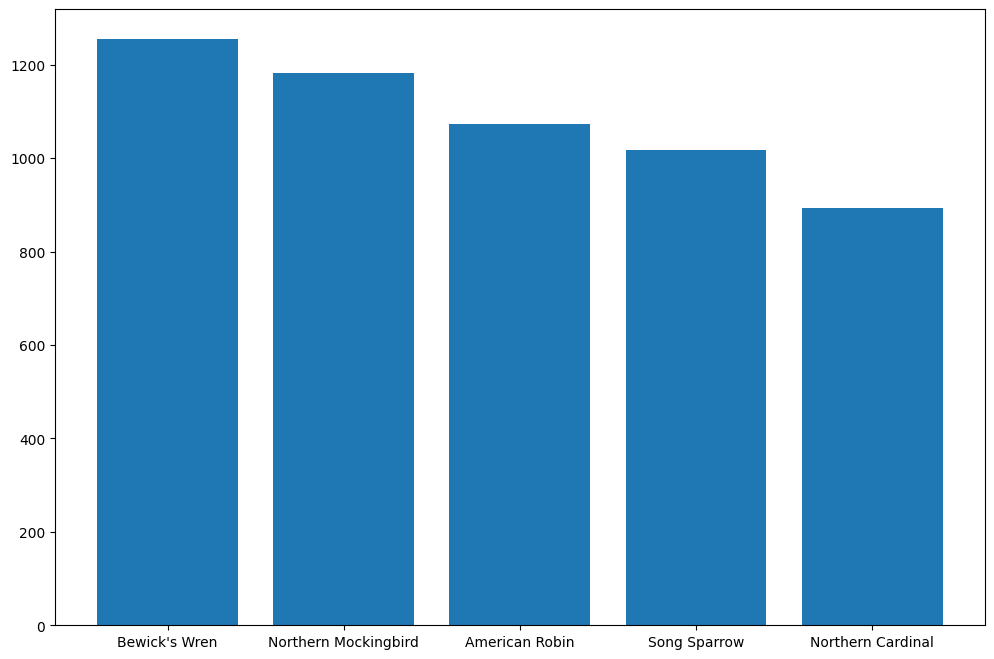

In [156]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(df["name"].unique(), df["name"].value_counts())

In [157]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [158]:
path_to_wav = "wavfiles/"


In [159]:
df_train = pd.DataFrame({"name": df["name"], "audiopath": path_to_wav + df["filename"]})

In [160]:
df_train["mfccs_scaled_features"] = df_train["audiopath"].apply(lambda x: features_extractor(x))

In [161]:
df_train["class"] = df_train["name"].factorize()[0]


In [162]:
from sklearn.utils import shuffle

df_train = shuffle(df_train)
df_train.shape

(5422, 4)

In [163]:
(train_x, train_y) = df_train["mfccs_scaled_features"][:5000].values, df_train["class"][:5000].values
(test_x, test_y) = df_train["mfccs_scaled_features"][5000:].values, df_train["class"][5000:].values

In [164]:
from keras.utils import to_categorical

test_y = to_categorical(test_y, num_classes=len(class_names))
train_y = to_categorical(train_y, num_classes=len(class_names))

In [165]:
train_x = np.stack(train_x[:])
test_x = np.stack(test_x[:])

train_x = tf.keras.utils.normalize(train_x)
test_x = tf.keras.utils.normalize(test_x)

train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))

In [166]:
train_x

array([[-9.3520218e-01,  5.9624951e-02, -2.9854071e-01, ...,
         1.2197710e-02, -8.0190031e-03,  6.5431953e-03],
       [-9.7786337e-01, -5.3444453e-02, -1.4601707e-01, ...,
         2.3076115e-03, -1.0761274e-02, -1.4986794e-03],
       [-8.8177937e-01, -6.0313415e-02, -3.9227685e-01, ...,
        -3.1483148e-03, -1.9672863e-02, -1.0297801e-03],
       ...,
       [-9.2531979e-01,  2.4179845e-01,  1.1150832e-02, ...,
         1.2551511e-02, -6.6921334e-03,  8.4235723e-04],
       [-8.5254401e-01,  3.6004874e-01, -1.3371129e-01, ...,
         9.6243182e-03, -3.7914693e-02,  1.1684658e-03],
       [-9.8154718e-01,  1.5797513e-03, -1.5284239e-01, ...,
         5.5288216e-03,  5.1762871e-03, -6.0055899e-03]], dtype=float32)

In [167]:
train_dataset = train_dataset.batch(10)
test_dataset = test_dataset.batch(10)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [168]:
train_x.shape

(5000, 40)

In [169]:
import keras
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Reshape, InputLayer, Dropout,Activation
from keras.models import Sequential

In [170]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(5))
model.add(Activation('softmax'))

In [171]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 100)               4100      
                                                                 
 activation_19 (Activation)  (None, 100)               0         
                                                                 
 dropout_16 (Dropout)        (None, 100)               0         
                                                                 
 dense_22 (Dense)            (None, 200)               20200     
                                                                 
 activation_20 (Activation)  (None, 200)               0         
                                                                 
 dropout_17 (Dropout)        (None, 200)               0         
                                                                 
 dense_23 (Dense)            (None, 100)              

In [172]:
model.compile('adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(), 'accuracy'])

In [173]:
classifier = model.fit(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50
500/500 [==============================] - 7s 12ms/step - loss: 1.4278 - recall_6: 0.0414 - precision_6: 0.5201 - accuracy: 0.3306 - val_loss: 1.1596 - val_recall_6: 0.0474 - val_precision_6: 0.7407 - val_accuracy: 0.4645
Epoch 2/50
500/500 [==============================] - 6s 11ms/step - loss: 1.1479 - recall_6: 0.2140 - precision_6: 0.5716 - accuracy: 0.4704 - val_loss: 1.0248 - val_recall_6: 0.2583 - val_precision_6: 0.6606 - val_accuracy: 0.5474
Epoch 3/50
500/500 [==============================] - 6s 11ms/step - loss: 1.0569 - recall_6: 0.3168 - precision_6: 0.6128 - accuracy: 0.5210 - val_loss: 0.9824 - val_recall_6: 0.3436 - val_precision_6: 0.6776 - val_accuracy: 0.5711
Epoch 4/50
500/500 [==============================] - 6s 11ms/step - loss: 1.0241 - recall_6: 0.3510 - precision_6: 0.6281 - accuracy: 0.5424 - val_loss: 0.9334 - val_recall_6: 0.4242 - val_precision_6: 0.6885 - val_accuracy: 0.6043
Epoch 5/50
500/500 [==============================] - 6s 12ms/step -

In [174]:
print(model.metrics_names)

['loss', 'recall_6', 'precision_6', 'accuracy']


In [175]:
pred_y = model.predict(test_x)
true_y = test_y.argmax(axis=1, keepdims=True)

14/14 [==============================] - 0s 3ms/step


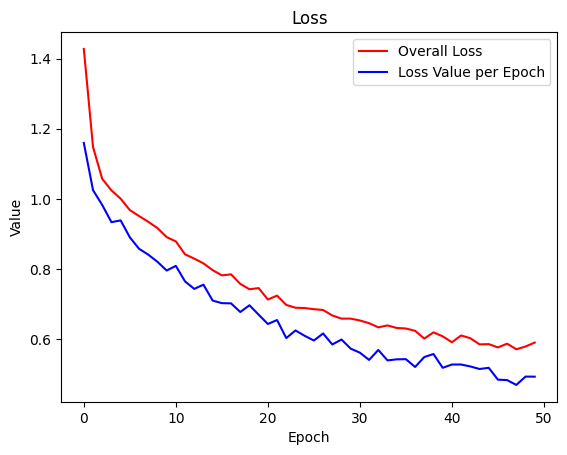

In [176]:
plt.title('Loss')
plt.plot(classifier.history['loss'], 'r', label='Overall Loss')
plt.plot(classifier.history['val_loss'], 'b', label='Loss Value per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

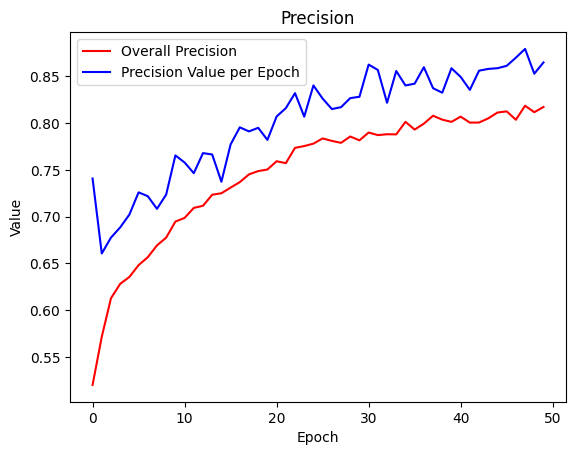

In [178]:
plt.title('Precision')
plt.plot(classifier.history['precision_6'], 'r', label='Overall Precision')
plt.plot(classifier.history['val_precision_6'], 'b', label='Precision Value per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [188]:
#manual testing for random
audio_file = 'wavfiles/111649-2.wav'
feature = features_extractor(audio_file)
mfccs_scaled_features=feature.reshape(1,-1)
normalized_data = tf.keras.utils.normalize(mfccs_scaled_features)

bird_list = ["Bewick's Wren", "Northern Mockingbird", "American Robin", "Song Sparrow", "Northern Cardinal"]

test=model.predict(normalized_data)
predicted_class = np.argmax(test, axis=1)
print(predicted_class)
predicted_bird = bird_list[predicted_class[0]]
print(predicted_bird)
# print(test[0][0])

# print(test)

1/1 [==============================] - 0s 22ms/step
[3]
Song Sparrow
